# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
1. View the SST data and spatial and temporal gradients
1. Make a prediction with assumed hyper-parameters
1. Perform Gaussian Process regression and inspect the hyper-parameter results
1. View the surface current predictions and uncertainties
1. Simulate particles advected by the predicted currents

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

**You will need a NASA earthdata login to download the Himawari data.**

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:184: SyntaxWarning: invalid escape sequence '\c'
  cbar_kwargs={'pad':0.03, 'shrink':0.5, 'label':'T [$^{\circ}$C]'})
/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [ ]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (144.5, 147)
LAT_LIMITS = (24, 26.5)  
ll_box = (LON_LIMITS, LAT_LIMITS)
time_str = "2025-05-12T00:00:00"

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', '../', 'example_data', 'himawari_tutorial_01')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##### Retrieve the required complete Himawari data files

By default this function will not overwrite existing files of the same name. 

This cell only needs to be run once - if you have the data comment this out. 

In [3]:
# # Download the data
# himawari.get_sst_scene_nasa(time_str, data_dir)

#### Process the scene

Compute the time and space tmeperature gradients.

**`sst_reduce`** is a key parameter that smoothes and thins the Himawari SST data. This is done to ensure advection length scales do not exceed the grid resolution (the Courant number must be less than 1). Users should define this based on local knowledge.

In [4]:
# Load the data
ds = himawari.process_sst_scene(data_dir, time_str, ll_box, sst_reduce=3)

  Finished processing for 2025-05-12T00:00:00


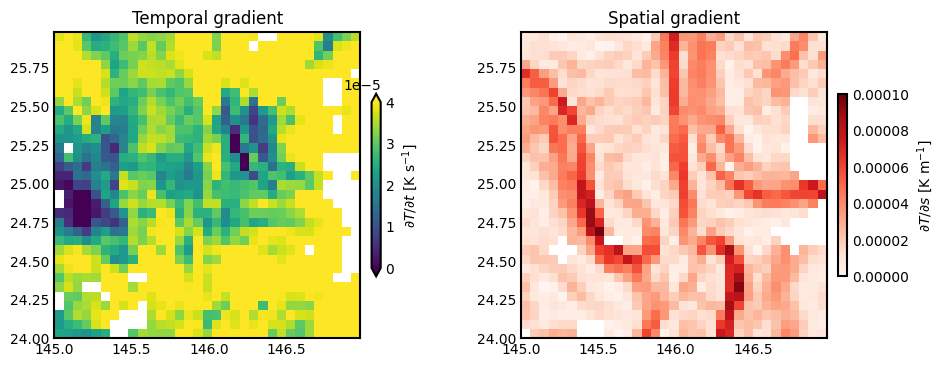

In [5]:
fig, ax = plots.plot_gradients(ds)

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

`predict_scene` has the option to output the full posterior covariance matrix (this is not saved for `predict_series`)

In [6]:
# Get an initial guess
guess_params = gpr.get_default_params()['initial_params']

print("Calculating GP regression prediction")
ds, Kpp = gpr.predict_scene(ds.isel(time=0), guess_params, full_cov=True)

Calculating GP regression prediction


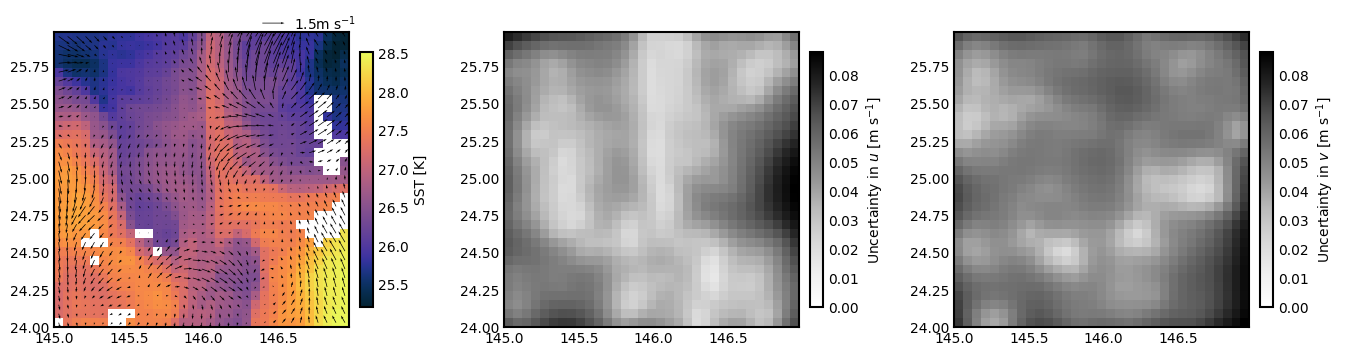

In [8]:
# Plot the mean estimation
fig, ax = plots.plot_prediction(ds, qk_size=1.5)

In [49]:
from inversion_sst_gp.plot_helper import draw_confidence_ellipse

def plot_pred_ellipses(ds, Kpp, n_std=1, scale=1, qv_scale=20, qk_size=1.0, qk_x=0.78, qk_y=1.03, an=True, **kwargs):

    fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'wspace':0.1})
    
    ds['T'].plot(ax=ax[0], cmap='cmo.thermal', add_colorbar=False)
    Q = ax[0].quiver(ds['LON'], ds['LAT'], ds['mu_u'], ds['mu_v'], scale=qv_scale)
        
    draw_confidence_ellipse(ax[1], ds['LON'], ds['LAT'], Kpp, n_std=n_std, scale=scale, an=an, **kwargs)
    ax[1].set_yticklabels('')

    for x in ax:
        x.set_aspect('equal')
        x.set_title('\u2007\u2007\u2007')
        x.set_xlabel('')
        x.set_ylabel('')
        x.set_xlim(ds['LON'].min(), ds['LON'].max())
        x.set_ylim(ds['LAT'].min(), ds['LAT'].max())

    qk = ax[0].quiverkey(
                    Q,
                    X=qk_x, Y=qk_y,      
                    U=qk_size,              
                    label=f'{qk_size:.1f}' + 'm s$^{-1}$',
                    labelpos='E',
                    coordinates='axes')       
    return fig, ax

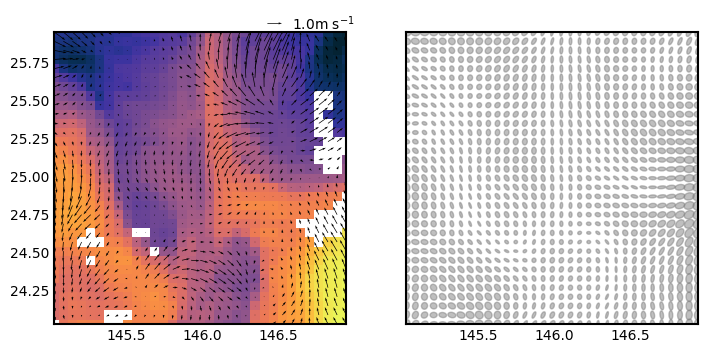

In [50]:
fig, ax = plot_pred_ellipses(ds, Kpp, scale=2.5, color='grey', alpha=0.5, an=False)

---
# Run the parameter optimization

In [ ]:
# Set model hyperparameters
prop_sat = gp_r.get_default_params()

# # Metric functions
# def run_gprm_optim(time_str, dTds1, dTds2, dTdt, X, Y, tstep, prop, callback="on"):
#     mask = np.ones_like(X, dtype=bool)
#     gprm = gp_r.GPRegressionJoint(dTds1, dTds2, dTdt, tstep, X, Y, mask)
#     est_params = gprm.estimate_params(**prop, callback=callback)
#     return {"step": time_str,
#             "est_params": est_params}

# Run model
print("Running GP optimization")
tstep = time_step
results = gpr.run_gprm_optim(
    time_str, dTds1o, dTds2o, dTdto, X, Y, tstep, prop_sat
)

results

Running GP optimization
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          4406.9     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01        

{'step': '2025-05-12T00:00:00',
 'est_params': {'sigma_u': np.float64(0.21210597854767085),
  'l_u': np.float64(11742.269774699633),
  'tau_u': np.float64(0.010054111061161743),
  'sigma_S': np.float64(1.1269198422252382e-05),
  'l_S': np.float64(19250.267576170427),
  'tau_S': np.float64(5.593195055841354e-07),
  'sigma_tau': np.float64(0.010913358368641062),
  'l_v': np.float64(11742.269774699633),
  'sigma_v': np.float64(0.21210597854767085),
  'tau_v': np.float64(0.010054111061161743)}}

In [11]:
print("Calculating GP regression prediction")
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_r.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, results['est_params'], X, Y, time_step))

ds['mu_u'] = (('lat', 'lon'), muustar)
ds['mu_v'] = (('lat', 'lon'), muvstar)
ds['std_u'] = (('lat', 'lon'), stdustar)
ds['std_v'] = (('lat', 'lon'), stdvstar)

Calculating GP regression prediction


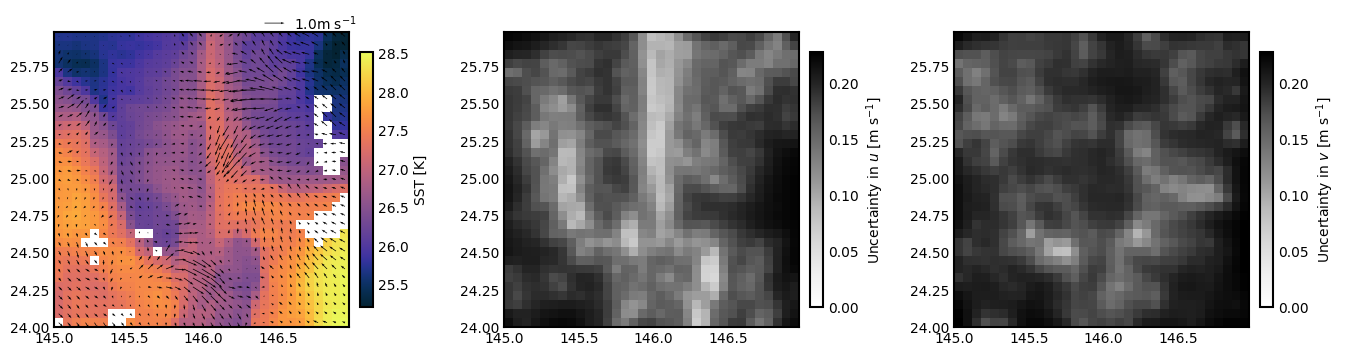

In [12]:
fig, ax = plots.plot_prediction(ds)

In [ ]:
full_file = himawari.get_himawari_file_path(data_dir, time_str, file_app='')
ds_himawari = xr.open_dataset(full_file)
ds_himawari